In [ ]:
%pip install sklearn-pandas


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy
from sklearn.ensemble import AdaBoostClassifier

In [11]:
#df=pd.read_csv("ks-projects-201801.csv")
x_train=pd.read_csv("./data/preprocess-base-x-train.csv")
y_train=pd.read_csv("./data/preprocess-base-y-train.csv")
x_valid=pd.read_csv("./data/preprocess-base-x-valid.csv")
y_valid=pd.read_csv("./data/preprocess-base-y-valid.csv")

In [12]:
def one_hot_df(df,one_hot_cols,drop_cols):
    dfret=deepcopy(df)
    dfret.astype({'launched_month': 'int32'})
    dfret=pd.get_dummies(dfret,columns=one_hot_cols).drop(columns=drop_cols)
    return dfret

one_hot_cols=['main_category','launched_month','deadline_month']
drop_cols=['category','Unnamed: 0']

x_train=one_hot_df(x_train, one_hot_cols,drop_cols)
x_valid=one_hot_df(x_valid,one_hot_cols,drop_cols)


Y_train=np.array(y_train['success'])
Y_valid=np.array(y_valid['success'])
feature_list=list(x_train.columns)
X_train=np.array(x_train)
X_valid=np.array(x_valid)

In [13]:
abc=AdaBoostClassifier(n_estimators=1000, random_state=42) #class_weight="balanced" or "balanced_subsample"
abc.fit(x_train[:1000],y_train[:1000])
print(abc.)

SyntaxError: invalid syntax (<ipython-input-13-dcadb1bbe379>, line 3)

In [6]:
predictions=abc.predict(X_vsmall)
errors=abs(predictions^Y_vsmall)
print('Mean Absolute Error:', round(np.mean(errors), 4))

NameError: name 'abc' is not defined

In [7]:
[print]

[<function print>]

In [14]:
x=1
estimators=[1]
for i in range(12):
    x*=2
    estimators+=[x]
    
print(estimators)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [34]:
l=[]
for i in range(5):
    p=i
    l.append(p)
print(l)

[0, 1, 2, 3, 4]


In [15]:
# estimator_weights_array of floats

#     Weights for each estimator in the boosted ensemble.
# estimator_errors_array of floats

#     Classification error for each estimator in the boosted ensemble.
# feature_importances_ndarray of shape (n_features,)
params=[]
predictions=[]
for i in range(len(estimators)):
    abc=AdaBoostClassifier(n_estimators=estimators[i], random_state=42)
    abc.fit(X_train,Y_train)
    p=abc.predict(X_valid)
    print(p)
    predictions.append(p)
    params.append(abc.get_params())

[False False False ... False False False]
[False False False ... False False False]
[False False  True ... False False  True]
[False False  True ... False False False]
[False False  True ... False False False]
[False False  True ... False False  True]
[False False  True ... False False False]
[False False  True ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]


MemoryError: 

In [33]:
#print(len(predictions))
#print(predictions)
print(type(predictions),type(predictions[0]))
for i in range(len(predictions)):
    for j in range(len(predictions)):
        if (predictions[i]!=predictions[j]).all():
            print(i,j)

<class 'list'> <class 'numpy.ndarray'>


In [17]:
accuracies=[]
mean_errors=[]
for i in predictions:
    errors=abs(predictions^Y_valid)
    mean_errors.append(round(np.mean(errors), 5))
    accuracies.append(1-round(np.mean(errors), 5))

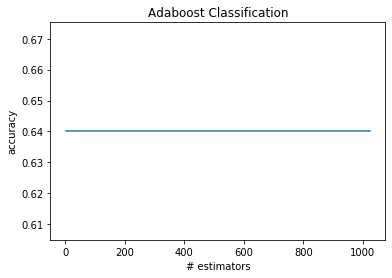

In [25]:
plt.plot(estimators[:-2],accuracies)
#plt.legend()
plt.title('Adaboost Classification')
plt.ylabel('accuracy')
plt.xlabel('# estimators')
plt.show()